**Anomaly Detection in Electrocardiogram using UMAP and LOF**

Dataset: "ECG Heartbeat Categorization Dataset" by Shayan Fazli (https://www.kaggle.com/shayanfazeli/heartbeat)

UMAP: "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" by Leland McInnes and Jogn Healy (https://umap-learn.readthedocs.io/en/latest/index.html)

Related work: https://umap-learn.readthedocs.io/en/latest/outliers.html

In [217]:
#Surasith Boonaneksap 2/22/2022
import numpy as np
import umap
import umap.plot
import matplotlib.pyplot as plt
import sklearn

**Step 1: Data Preparation**

1.1 Data Loading and Preprocessing

In [218]:
norm = np.loadtxt("./data/ptbdb_normal.csv", delimiter=",")
abnorm = np.loadtxt("./data/ptbdb_abnormal.csv", delimiter=",")

In [219]:
# Randomize
np.random.shuffle(norm)
np.random.shuffle(abnorm)

1.2 Plot Samples of Normal and Abnormal ECG

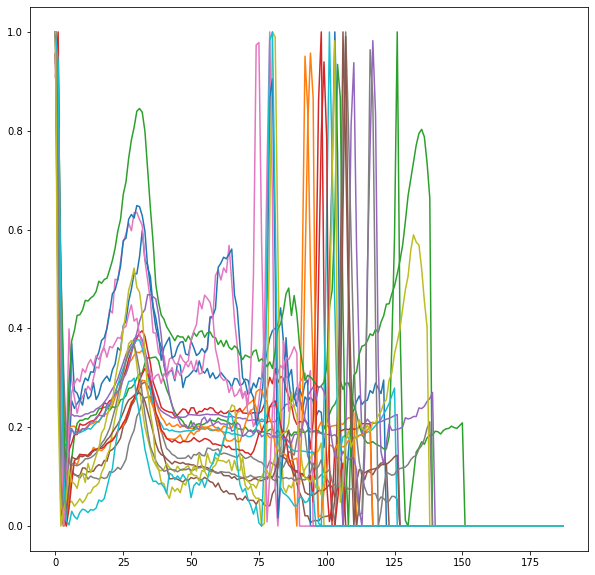

In [220]:
# Plot the first 20 samples
plt.figure(figsize=(10,10))
for i in range(20):
    plt.plot(norm[i])
plt.show()

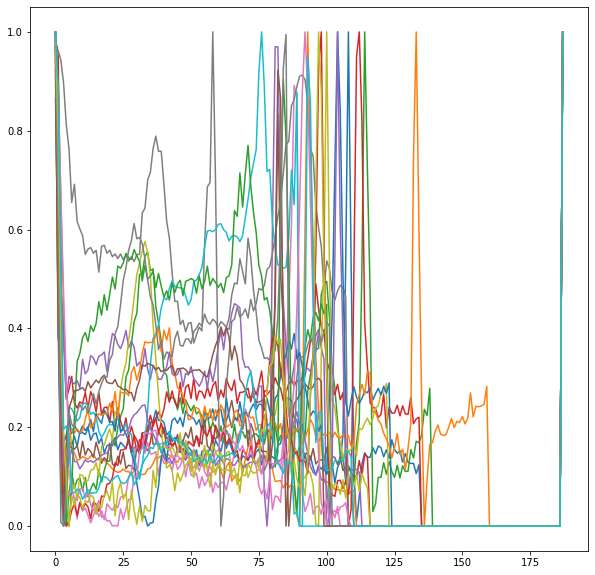

In [221]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.plot(abnorm[i])
plt.show()

1.3 Creating the Training and Testing Set

In [222]:
LOF_TRAIN_N = 2000
LOF_TEST_POS_N = 250
LOF_TEST_NEG_N = 250
UMAP_TRAIN_N = 2000
UMAP_RATIO = 0.7

lof_train    = norm[:LOF_TRAIN_N]
lof_test_pos = abnorm[:LOF_TEST_POS_N]
lof_test_neg = norm[LOF_TRAIN_N:LOF_TRAIN_N+LOF_TEST_NEG_N]

# UMAP needs to be trained on both normal and abnormal data.
# Performance will be impacted if there is not enough representation of abnormal data.
# Similar to the related work where all data are used for training.
umap_train   = np.concatenate( 
                              (norm[LOF_TRAIN_N+LOF_TEST_NEG_N : LOF_TRAIN_N+LOF_TEST_NEG_N+int(UMAP_TRAIN_N*UMAP_RATIO)], 
                               abnorm[LOF_TEST_POS_N : LOF_TEST_POS_N+int(UMAP_TRAIN_N*(1-UMAP_RATIO))])
                             )

**Step 2: Non-linear Dimensionality Reduction using UMAP**

2.1 Create a UMAP instance 

In [223]:
reducer = umap.UMAP(
    n_components = 2,
    n_neighbors = 10,
    min_dist = 0.1
    ).fit(umap_train)

2.2 Reduce the Number of Dimensions in the Testing Set

In [224]:
lof_test_neg_emb = reducer.transform(lof_test_neg)
lof_test_pos_emb = reducer.transform(lof_test_pos)

2.3 Visualizes the Testing Set mapped to 2D Space

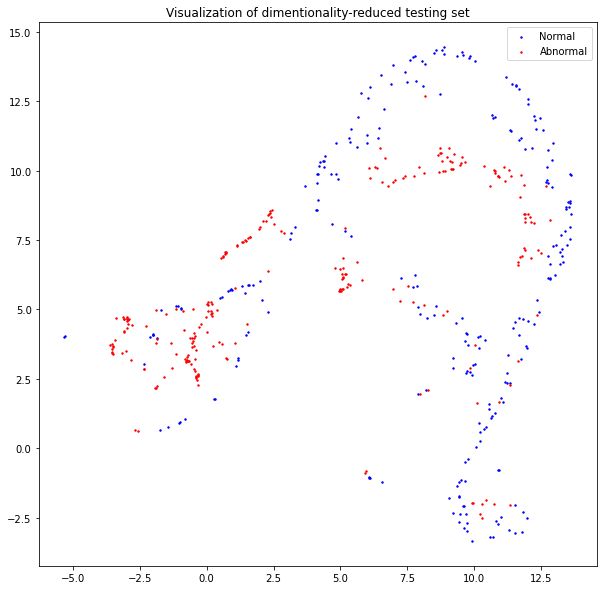

In [225]:
x_norm, y_norm = np.split(lof_test_neg_emb, 2, 1)
x_abnorm, y_abnorm = np.split(lof_test_pos_emb, 2, 1)

plt.figure(figsize=(10,10))
plt.scatter(x_norm, y_norm,label="Normal",c="blue", s=2)
plt.scatter(x_abnorm, y_abnorm,label="Abnormal", c="red", s=2)
plt.title("Visualization of dimentionality-reduced testing set")
plt.legend()
plt.show()

**Step 3: Novelty Detection using LOF**

In [236]:
# The LOF is fitted with only negative (normal) data
detector = sklearn.neighbors.LocalOutlierFactor(novelty=True)
_ = detector.fit( reducer.transform(lof_train) )

**Step 4: Evaluation**

In [237]:
tp = np.count_nonzero( detector.predict( lof_test_pos_emb ) == -1 ) # Outlier = -1
tn = np.count_nonzero( detector.predict( lof_test_neg_emb ) == 1 ) # Inliner = 1

fn = lof_test_pos_emb.shape[0] - tp
fp = lof_test_neg_emb.shape[0] - tn

In [238]:
acc = float(tp+tn) / (tp+tn+fp+fn)
sen = float(tp) / (tp+fn)
spe = float(tn) / (tn+fp)

In [239]:
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"")
print(f"Accuracy: {acc*100}%")
print(f"Sensitivity/Recall: {sen*100}%")
print(f"Specificity: {spe*100}%")

True Positives: 193
True Negatives: 243
False Positives: 7
False Negatives: 57

Accuracy: 87.2%
Sensitivity/Recall: 77.2%
Specificity: 97.2%
